# Module 8 Lab - Logistic Regression

## Directions

1. Show all work/steps/calculations. If it is easier to write it out by hand, do so and submit a scanned PDF in addition to this notebook. Otherwise, generate a Markdown cell for each answer.
2. You must submit to **two** places by the deadline:
    1. In the Lab section of the Course Module where you downloaded this file from, and
    2. In your Lab Discussion Group, in the forum for the appropriate Module.
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In [1]:
%matplotlib inline

import pandas as pd
import patsy
import matplotlib.pyplot as plt
import numpy as np
import random as py_random
import seaborn as sns
import sklearn.linear_model as linear
import scipy.stats as stats

sns.set(style="darkgrid")

# Set the Seed we'll use
SEED = 1477102575

# Set the random number seed.  Called before each experiment.
def set_seed():
    np.random.seed(SEED)
    py_random.seed(SEED)

# [1]
# generates the logistic 
def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

# Get samples from a normal distribution
def normal_dist(mean, stddev, size=1000):
    return np.random.normal(loc=mean, scale=stddev, size=size)

# Get samples from a standard normal distribution (mean = 0, stddev = 1)
def standard_normal_dist(samples=1000):
    return np.random.standard_normal(size=samples)

# Run a Bernoulli trial given probability p, with an optional # of samples
def bernoulli_trial(p, samples=1):
    if samples == 1:
        return 1 if py_random.random() < p else 0
    else:
        return [1 if py_random.random() < p else 0 for _ in range(samples)]
    
# [2]
def logm(formula, data=None):
    if data is None:
        raise ValueError("The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame.")
    
    result = {}
    result['formula'] = formula
    result['n'] = data.shape[0]

    y, X = patsy.dmatrices(formula, data, return_type='matrix')
    y = np.ravel(y) # not sure why this is needed for LogisticRegression but no LinearRegression

    model = linear.LogisticRegression(fit_intercept=False).fit(X, y)
    result['coefficients'] = model.coef_[0]

    y_hat = model.predict(X)
    result['residuals'] = y - y_hat
    return result

# [3]
def bootstrap_logm( formula, data=None, samples=100):
    if data is None:
        raise ValueError("The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    
    # Setup result 
    result = {}
    result['data'] = data
    result['formula'] = formula
#    variables = map(lambda x: x.strip(), formula.split("~")[1].split("+"))
    variables = [x.strip() for x in formula.split("~")[1].split("+")]
    variables = ['intercept'] + variables
    result['variables'] = variables
    
    n = data.shape[0]
    result['n'] = n
    
    coeffs = []
    # Bootstrap the model to get coefficients
    for i in range(samples):
        indices = [i for i in [np.random.randint(0, n-1) for _ in range(0, n)]]
        sampling = data.loc[indices]
        r = logm(formula, data=sampling)
        coeffs.append(r['coefficients'])
    
    result['resampled_coefficients'] = pd.DataFrame(coeffs, columns=variables)
    
    # run the logistic regression model 1 more time
    r = logm(formula, data=data)
    result['residuals'] = r['residuals']
    result['coefficients'] = r['coefficients']
    return result

# [3]
def describe_bootstrap_fit(result):
    print( "Regression: {0}".format(result['formula']))
    print( "n: {0}".format(result['n']))
    print( "----------")
    
    bounds = result['resampled_coefficients'].quantile([0.025, 0.975])
    bounds = bounds.transpose()
    bounds = bounds.values.tolist()
    
    for variable, coefficient, bound in zip(result['variables'], result['coefficients'], bounds):
        print( "{0}: {1}  95% CI: {2}".format(variable, coefficient, bound))
        

# [2]
def logistic_slope_at(beta, model):
    return (beta * np.exp( beta * model)) / (1.0 + np.exp( beta * model))**2



# Describe the coefficients in a result using a specific technique (or all)
def desc_coefficients(result):
    print( "Coefficients Described:")
    
    # Describe each coefficient using the Divide By 4 & Derivative methods
    # Get the bounds for each coefficient
    bounds = result['resampled_coefficients'].quantile([0.025, 0.975])
    bounds = bounds.transpose()
    bounds = bounds.values.tolist()
    
    # Decribe the intercept first
    print( "\n[Intercept Analysis]:")
    intercept = result['coefficients'][0]
    lower, upper = bounds[0][0], bounds[0][1]
    p = logistic(intercept)
    p_l = logistic(lower)
    p_u = logistic(upper)
    description = "P(y=1) is {0:.2F}% ".format(p * 100)
    description += " with a 95% CI of {0:.2F}% to {1:.2F}%".format(p_l * 100, p_u * 100)
    description += " when variables: {0} are at 0.".format(result['variables'][1:])
    print( description)
    
    # Describe the remaining coefficients using the Divide by 4 Method
    print( "\n[Divide by 4 Analysis]:")
    for variable, beta, bound in zip(result['variables'][1:], result['coefficients'][1:], bounds[1:]):
        
        # Divide by 4
        b = beta / 4
        l = bound[0]/4
        u = bound[1]/4
        description = "A unit change in {0} at its mean would change".format(variable)
        description += " P(y=1) by {0:.2F}%".format(b * 100)
        description += " with a 95% CI of {0:.2F}% to {1:.2F}%".format(l * 100, u * 100)
        print( description)
    
    # Decribe the remaining coefficients using the Derivative Method
    print( "\n[Derivative at Mean of Regressor Analysis]:")
    for variable, beta, bound in zip(result['variables'][1:], result['coefficients'][1:], bounds[1:]):

        # Derivative 
        b = logistic_slope_at(beta, np.mean(result['data'][variable]))
        l = logistic_slope_at(bound[0], np.mean(result['data'][variable]))
        u = logistic_slope_at(bound[1], np.mean(result['data'][variable]))
        description = "A unit change in {0} at its mean would change".format(variable)
        description += " P(y=1) by {0:.2F}%".format(b * 100)
        description += " with a 95% CI of {0:.2F}% to {1:.2F}%".format(l * 100, u * 100)
        print( description)

You're going to follow the same basic pattern you did last week. You're going to generate data and see if you can recover the model. I'll get you started.

## Logistic Regression

Logistic Regression is a bit harder to work with than Linear Regression when it comes to generating data. This is because the $\beta$s aren't generally what we think they are and because the $logistic$ function is non-linear.

One of the general suggestions for Regression is that you work in mean centered space. This allows you to interpret the coefficients a bit more easily. Now, I did not have you do this last week for Linear Regression because it wasn't really necessary. However, this week, it is much easier to work in mean centered space when generating the data and then transform the data out into raw data when you're done. This is just one additional complication that working with Logistic Regression creates. Let's look at the basic model. It has two parts:

$z = \beta_0$

$y = \frac{1}{1+e^{-z}}$

The first thing to notice is that there's no $\epsilon$. Why? Because the error in a logistic regression isn't normally distributed, it's logistically distributed. This shows that there's a relationship in the General Linear Model (GLM) between the "error" (known unknowns and unknown unknowns) and the linking function.

Remember that absent a transformation, the $\beta$s are *log odds*. This means that:

$z = \beta_0$ is the base log odds.

$z = \beta_0 + \beta_1 X_1$ is a positive change to *those* log odds based on $X_1$

$z = \beta_0 + \beta_1 X_1 - \beta_2 X_2$ is a negative change *those* log odds based on $X_2$

and so on but log odds are difficult to think about.

### Divide by Four? Multiply by Four.

We can, however, do a trick. Remember the "Divide By 4" rule of thumb for interpreting a coefficient ($\beta$) in the context of the average value of $X_i$? We can do the same thing here but in reverse:

1. Think of the base probability you want and multiply by 4, that is $\beta_0$.
2. For each predictor/factor you want to add $X_i$, think about how you want it to adjust the base probability and by how much *at the average value* of $X_i$ and multiply by 4 to get the $\beta_i$ you want.

But that also means that the $X_i$ should be mean centered when you use it in the function.  You can transform it later into "raw" data by picking values for the mean and standard deviation. You may have to play with magnitudes to get things to behave.

Now, after you have decided on your function, the following algorithm is to be used. This is a non-vectorized version:

```
1. generate Xs using the standard normal distribution or binomial if categorical.
2. initialize ys
3. for each data point:
4.     z = f(beta, Xs)
5.     pr = 1/(1_exp(-z))
6.     y = 1 if rand() < pr else 0
7.     add y to ys
8. translate X's to raw data.
```

then see if you can recover your $\beta$s.

**1\. Just so we can see if we're all on the same page, the following data and use the Bootstrap version of the *Logistic* Regression and recover the coefficients ($\beta$s). Interpret the coefficients, the Bootstrap estimates and plot the Logistic Regression using the XZ-space/decision boundary approach.**

Generate 1000 samples from...

$X_1$ is normally distributed with $\mu=0.0$ and $\sigma=1.0$ (standard normal).

$X_2$ is standard normally distributed.

$z = 1.0 + 2.0 X_1 + 3 X_2$

$p = \frac{1}{1+e^{-z}}$

use p to generate ys as a bernoulli trial.

In [2]:
# Starting experiment
set_seed()

# Generate Xs
X1 = standard_normal_dist(samples=1000)
X2 = standard_normal_dist(samples=1000)

# Generate Ys
Y = []
for x1,x2 in zip(X1,X2):
    z = 1.0 + (2.0 * x1) + (3 * x2)
    p = logistic(z)
    Y.append(bernoulli_trial(p))

    
data = pd.DataFrame.from_records(data=zip(Y,X1,X2), columns=['Y','X1','X2'])
result = bootstrap_logm('Y ~ X1 + X2', data=data)
describe_bootstrap_fit(result)

Regression: Y ~ X1 + X2
n: 1000
----------
intercept: 1.1553802196602045  95% CI: [0.9436886360003789, 1.3999352761504016]
X1: 1.9278984502198553  95% CI: [1.6732789025306514, 2.26456221531525]
X2: 3.0708947563962763  95% CI: [2.745853545572519, 3.613823984884638]


It looks like we're able to successfully recover our coefficients indicating the implementationg is working, ableit with a bit of error since we're working with samples:
- intercept ($\beta_0$) is 1.15.  Original value was 1
- $\beta_1$ is 1.93. Original value was 2
- $\beta_2$ is 3.08. Original value was 3. 


_Interpretting Coefficients & Bootstrap estimates_

We can use the definition $P(y=1) = {logit^1}(1.155 + 1.927X_1 + 3.07X_2)$ to interpret the intercept $\beta_0$. The intercept represents the log odds of $y=1$ when $x_1 = 0$ and $x_2 = 0$. We can get the actual probability and 95% Confidence Interval (CI) by applying the $logistic$ function to the intercept and the bounds returned for it from the bootstrap:

In [3]:
# Interpret the intercept
intercept = result['coefficients'][0]
p = logistic(intercept)

# Get 95% CI
bounds = result['resampled_coefficients'].quantile([0.025, 0.975])
bounds = bounds.transpose()
bounds = bounds.values.tolist()
lower, upper = bounds[0][0], bounds[0][1]
lower_p = logistic(lower)
upper_p = logistic(upper)

print( "P(y=1) is {0:.2F}%, with a 95% CI of {1:.2F}% to {2:.2F}%, when x1=0 and x2=0".format(p * 100
                                                                                          , lower_p * 100
                                                                                          , upper_p * 100))

P(y=1) is 76.05%, with a 95% CI of 71.98% to 80.22%, when x1=0 and x2=0


Interpretting the coefficients for $X_1$ ($\beta_1$) and $X_2$ ($\beta_2$) is a little more involved. One approach is to quantify the change in probability that a coefficient (e.g. $\beta_1$) causes when its corresponding variable ($X_1$) undergoes a unit change, while leaving the other regressor(s) at the mean ($x_2 = \bar{X_2}$):

In [4]:
# Get coefficients
b0 = result['coefficients'][0]
b1 = result['coefficients'][1]
b2 = result['coefficients'][2]

# Shift X1 by 1
diffs = []
for s in result['resampled_coefficients']['X1']:
    p = logistic(b0 + (s * np.mean(X1)) + (b2 * np.mean(X2)))
    p1 = logistic(b0 + (s * (np.mean(X1) + 1)) + (b2 * np.mean(X2)))
    diffs.append(p1-p)
ci = stats.mstats.mquantiles(diffs, [0.025, 0.975])
lower, upper = ci[0], ci[1]

p = logistic(b0 + (b1 * np.mean(X1)) + (b2 * np.mean(X2)))
p1 = logistic(b0 + (b1 * (np.mean(X1) + 1)) + (b2 * np.mean(X2)))
diff = p1 - p
print( "---------------------")
print( "Evaluating +1 increase in X1:")
print( "P(y=1) when x1={0} and x2={1} is {2:.2F}%".format(np.mean(X1), np.mean(X2), p * 100))
print( "P(y=1) when x1={0} and x2={1} is {2:.2F}%".format(np.mean(X1)+1, np.mean(X2), p1 * 100))
print( "Increase in P(y=1) of {0:.2F}% with a 95% CI of: {1:.2F}% to {2:.2F}%".format(diff * 100, 
                                                                                     lower * 100, 
                                                                                     upper * 100))


# Shift X2 by 1
diffs = []
for s in result['resampled_coefficients']['X2']:
    p = logistic(b0 + (b1 * np.mean(X1)) + (b2 * np.mean(X2)))
    p1 = logistic(b0 + (b1 * np.mean(X1)) + (b2 * (np.mean(X2) + 1)))
    diffs.append(p1 - p)
ci = stats.mstats.mquantiles(diffs, [0.025, 0.975])
lower, upper = ci[0], ci[1]

p = logistic(b0 + (b1 * np.mean(X1)) + (b2 * np.mean(X2)))
p1 = logistic(b0 + (b1 * np.mean(X1)) + (b2 * (np.mean(X2) +1)))
diff = p1 - p
print( "\nEvaluating +1 increase in X2:")
print( "P(y=1) when x1={0} and x2={1} is {2:.2F}%".format(np.mean(X1), np.mean(X2), p * 100))
print( "P(y=1) when x1={0} and x2={1} is {2:.2F}%".format(np.mean(X1), np.mean(X2) + 1, p1 * 100))
print( "Increase in P(y=1) of {0:.2F}% with a 95% CI of: {1:.2F}% to {2:.2F}%".format(diff * 100,
                                                                                     lower * 100,
                                                                                     upper * 100))

---------------------
Evaluating +1 increase in X1:
P(y=1) when x1=0.015076927162187757 and x2=-0.03577892725408282 is 74.55%
P(y=1) when x1=1.0150769271621878 and x2=-0.03577892725408282 is 95.27%
Increase in P(y=1) of 20.72% with a 95% CI of: 19.31% to 21.99%

Evaluating +1 increase in X2:
P(y=1) when x1=0.015076927162187757 and x2=-0.03577892725408282 is 74.55%
P(y=1) when x1=0.015076927162187757 and x2=0.9642210727459172 is 98.44%
Increase in P(y=1) of 23.89% with a 95% CI of: 23.89% to 23.89%


Another approach is to apply the **Divide By 4 Rule**, which is a general rule of thumb for evaluating how much a unit change in a regressor ($X$) at its mean has on the probability that Y=1 thanks to its coefficient $\beta$:

In [5]:
# Get 95% CI
bounds = result['resampled_coefficients'].quantile([0.025, 0.975])
bounds = bounds.transpose()
bounds = bounds.values.tolist()

# get betas
pb1 = result['coefficients'][1] / 4
pb1_l, pb1_h = bounds[1][0] / 4 , bounds[1][1] / 4
description = "A unit change in X1 at its mean would increase P(Y=1) by {0:.2F}%".format(pb1 * 100)
description += " with a 95% CI of {0:.2F}% to {1:.2F}%".format(pb1_l * 100, pb1_h * 100)
print( description)

pb2 = result['coefficients'][2] / 4
pb2_l, pb2_h = bounds[2][0] / 4 , bounds[2][1] / 4
description = "A unit change in X2 at its mean would increase P(Y=1) by {0:.2F}%".format(pb2 * 100)
description += " with a 95% CI of {0:.2F}% to {1:.2F}%".format(pb2_l * 100, pb2_h * 100)
print( description)

A unit change in X1 at its mean would increase P(Y=1) by 48.20% with a 95% CI of 41.83% to 56.61%
A unit change in X2 at its mean would increase P(Y=1) by 76.77% with a 95% CI of 68.65% to 90.35%


Finally, a third method for evaluating the coefficients it take the derivative of the logistic and evaluate it at the mean of the variable $X$ for the coefficient $\beta$ we are interested in interpretting:

In [6]:
# Get 95% CI
bounds = result['resampled_coefficients'].quantile([0.025, 0.975])
bounds = bounds.transpose()
bounds = bounds.values.tolist()

# Beta 1
b1 = result['coefficients'][1]
pb1 = logistic_slope_at(b1, np.mean(result['data']['X1']))

b1_l, b1_h = bounds[1][0], bounds[1][1]
pb1_l = logistic_slope_at(b1_l, np.mean(result['data']['X1']))
pb1_h = logistic_slope_at(b1_h, np.mean(result['data']['X1']))
description = "A unit change in X1 at its mean would increase P(Y=1) by {0:.2F}%".format(pb1 * 100)
description += " with a 95% CI of {0:.2F}% to {1:.2F}%".format(pb1_l * 100, pb1_h * 100)
print( description)

# Beta 2
b2 = result['coefficients'][2]
pb2 = logistic_slope_at(b2, np.mean(result['data']['X2']))

b2_l, b2_h = bounds[2][0], bounds[2][1]
pb2_l = logistic_slope_at(b2_l, np.mean(result['data']['X2']))
pb2_h = logistic_slope_at(b2_h, np.mean(result['data']['X2']))
description = "A unit change in X2 at its mean would increase P(Y=1) by {0:.2F}%".format(pb2 * 100)
description += " with a 95% CI of {0:.2F}% to {1:.2F}%".format(pb2_l * 100, pb2_h * 100)
print( description)

A unit change in X1 at its mean would increase P(Y=1) by 48.19% with a 95% CI of 41.83% to 56.60%
A unit change in X2 at its mean would increase P(Y=1) by 76.54% with a 95% CI of 68.48% to 89.97%


_Plotting the Regression_:

Here we'll plot the regression using the XZ-space technique from Module 8:

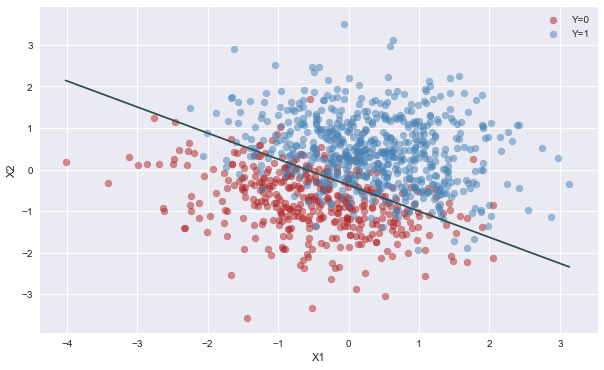

In [7]:
# Plot it
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)

# Scatter plot of Y = 1 and Y = 0 
df = result['data']
dy0 = df[df['Y'] == 0]
dy1 = df[df['Y'] == 1]     
axes.scatter(dy0['X1'], dy0['X2'], color='firebrick', alpha=0.5, label='Y=0')
axes.scatter(dy1['X1'], dy1['X2'], color='steelblue', alpha=0.5, label='Y=1')
axes.set_xlabel('X1')
axes.set_ylabel('X2')
axes.legend()

# plot X2 against X1 (decision boundary)
xs = np.linspace(df['X1'].min(), df['X1'].max(), 100)
b0 = result['coefficients'][0]
b1 = result['coefficients'][1]
b2 = result['coefficients'][2]
ys = [-((b0 + (b1 * x)) / b2) for x in xs]

axes.plot(xs, ys, color='darkslategrey')
plt.show()

---------------

**2\.** Because the Logistic Regression is a bit harder, I'm going to only ask you for 3 Experiments but you should follow the same advice as was given for the Linear Regression. Make 3 functions and try to recover them, using the techniques that were discussed in the Module. The more elements you can add, the more twisted you can make the relationships, the better you will be at doing and interpreting *real* data with a *real* logistic regression.

_Experiment #1:_ 

Modify **1** as follows:
- $X_1$ should be sampled from the standard normal distribution ($\mu=0$, $\sigma=1$)
- $X_2$ should be sampled from the standard normal distribution ($\mu=0$, $\sigma=1$)
- z is now defined as $z = .4 + .5X_1 + .4125X_2$

The intent is to determine the impact that the reduced coefficients has on the model in comparison to the results observed in *1*.  Try to answer the questions:
- How was the validity/interpretability of the model impacted?
- How was the plot & decision boundary impacted?

Regression: Y ~ X1 + X2
n: 1000
----------
intercept: 0.4378512062754093  95% CI: [0.25528953464095805, 0.5838852707934608]
X1: 0.5331152675394196  95% CI: [0.3725409875645359, 0.6907233919485181]
X2: 0.48711735772528664  95% CI: [0.3618145781236395, 0.637847975187305]
------------------
Coefficients Described:

[Intercept Analysis]:
P(y=1) is 60.77%  with a 95% CI of 56.35% to 64.20% when variables: ['X1', 'X2'] are at 0.

[Divide by 4 Analysis]:
A unit change in X1 at its mean would change P(y=1) by 13.33% with a 95% CI of 9.31% to 17.27%
A unit change in X2 at its mean would change P(y=1) by 12.18% with a 95% CI of 9.05% to 15.95%

[Derivative at Mean of Regressor Analysis]:
A unit change in X1 at its mean would change P(y=1) by 13.33% with a 95% CI of 9.31% to 17.27%
A unit change in X2 at its mean would change P(y=1) by 12.18% with a 95% CI of 9.04% to 15.94%
------------------


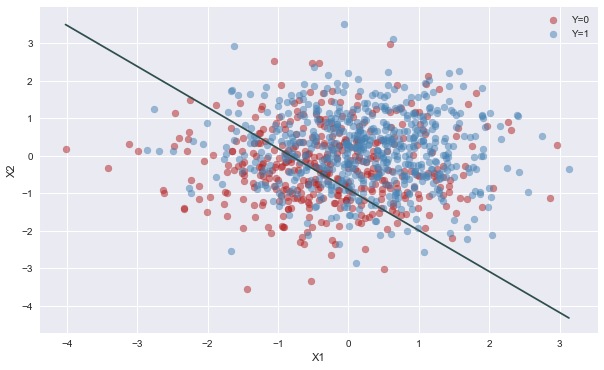

In [8]:
# Defines Experiment 1
def experiment_1():
    
    # Set random seed
    set_seed()
    
    # Generating X1, X2 & Y
    X1 = normal_dist(mean=0, stddev=1, size=1000)
    X2 = normal_dist(mean=0, stddev=1, size=1000)
    Y = []
    for x1,x2 in zip(X1,X2):
        z = .4 + (.5 * x1) + (.4125 * x2)
        p = logistic(z)
        Y.append(bernoulli_trial(p))
        
    # Run the logm bootstrap
    data = pd.DataFrame.from_records(data=zip(Y,X1,X2), columns=['Y','X1','X2'])
    result = bootstrap_logm('Y ~ X1 + X2', data=data)
    describe_bootstrap_fit(result)
    
    # Interpret the coefficients
    print( "------------------")
    desc_coefficients(result)
    print( "------------------")
    
    # Plot it
    figure = plt.figure(figsize=(10,6))
    axes = figure.add_subplot(1,1,1)

    # Scatter plot of Y = 1 & Y = 0 
    df = result['data']
    dy0 = df[df['Y'] == 0]
    dy1 = df[df['Y'] == 1]     
    axes.scatter(dy0['X1'], dy0['X2'], color='firebrick', alpha=0.5, label='Y=0')
    axes.scatter(dy1['X1'], dy1['X2'], color='steelblue', alpha=0.5, label='Y=1')
    axes.set_xlabel('X1')
    axes.set_ylabel('X2')
    axes.legend()

    # plot X2 against X1 (decision boundary)
    x1s = np.linspace(df['X1'].min(), df['X1'].max(), 100)
    b0 = result['coefficients'][0]
    b1 = result['coefficients'][1]
    b2 = result['coefficients'][2]
    x2s = [-((b0 + (b1 * x)) / b2) for x in x1s]

    axes.plot(x1s, x2s, color='darkslategrey')
    plt.show()
    
    
# Run experiment 1 
experiment_1()

**Observations**:

The most readily obvious fact is that there are more instances of Y=0 thanks to the reduced overall probability. In the case of $X_1 = 0$ and $X_2 = 0$,  the intercept is now interpretted to mean there is only a 60.77% chance of y=1. Not surprising, the 95% confidence intervals around the intercept have shifted accordingly, but span a similar number of percentage points (~8-9%), reflecting that all we've really done was downshift the impact the original $X_0$ and $X_1$ have in the model.

Similarly, when interpretting $\beta_1$ and $\beta_2$ we see a reduced change in $P(y=1)$ when moving about the mean thanks to the decreased weights. The % impact of a shift in $X_1$ is higher than that of a shift in $X_2$ thanks again to the higher weight on $X_1$.

The most interesting part appears to be the plot though. There is less obvious separation between instances of $Y=0$ and $Y=1$ across the $X_1, X_2$ sample space, with a lot more $Y=0$ interspersed in the higher values of $X_1, X_2$.  This appears to reflect the decrease in the intercept $\beta_0$.


-------

_Experiment #2:_

Now try using categorical variables.  We'll use the following guidlines:
- We want a base probability of 50%  for $P(Y=1)$:
 - $z = \beta_0 = 0$
 - $p =\frac{1}{1 + e^{-z}} => \frac{1}{1 + e^{0}} = \frac{1}{1+1} = \frac{1}{2} = .5$
- $X_1$ will be a indicator regressor that is active 25% of the time, therefore sampled from the binomial distribution (0,1) with $p = .25$
- when $X_1$=1, we'd like to see $P(y=1) = .75$. Using the divide by 4 instructions above, we'll set z:
 - $z = 0 + 2X_1$
 
How does the presence of the categorical variable influence interpretting the results? 

In [9]:
def experiment_2():
    
    # Set random seed
    set_seed()
    
    X1 = bernoulli_trial(.25, samples=1000)
    Y = []
    for x1 in X1:
        z = 0 + (2 * x1)
        p = logistic(z)
        Y.append(bernoulli_trial(p))
        
    # Run the logm bootstrap
    data = pd.DataFrame.from_records(data=zip(Y,X1), columns=['Y','X1'])
    result = bootstrap_logm('Y ~ X1', data=data)
    describe_bootstrap_fit(result)
    
    # Interpret the coefficients
    print( "------------------")
    desc_coefficients(result)
    print( "------------------")
    return result

    
# Run experiment 2
result = experiment_2()

Regression: Y ~ X1
n: 1000
----------
intercept: 0.13789736536355202  95% CI: [0.005278080127435485, 0.2696779753147356]
X1: 1.6085609042258773  95% CI: [1.21710948835825, 2.0223930712414937]
------------------
Coefficients Described:

[Intercept Analysis]:
P(y=1) is 53.44%  with a 95% CI of 50.13% to 56.70% when variables: ['X1'] are at 0.

[Divide by 4 Analysis]:
A unit change in X1 at its mean would change P(y=1) by 40.21% with a 95% CI of 30.43% to 50.56%

[Derivative at Mean of Regressor Analysis]:
A unit change in X1 at its mean would change P(y=1) by 38.51% with a 95% CI of 29.68% to 47.22%
------------------


Our intercept looks correct given the stated goals. However, it is actually rather challenging to interpret the coefficient for $X_1$ in any meaningful fashion, since we really don't think of $X_1$ as having a "mean" in a practical sense - rather it is on ($X_1 = 1$) or off ($X_1 = 0$). We can then evaluate the coefficients at $X_1=0$ and $X_1=1$ separately, using the logistic:

In [10]:
# Get the coefficients
b0 = result['coefficients'][0]
b0_samples = result['resampled_coefficients']['intercept']
b1 = result['coefficients'][1]
b1_samples = result['resampled_coefficients']['X1']

# Get the delta in probability based on all our sampled coefficients
diffs = []
for b0,b1 in zip(b0_samples, b1_samples):
    p = logistic(b0 + (b1 * 0))
    p1 = logistic(b0 + (b1 * 1))
    diffs.append(p1-p)

ci = stats.mstats.mquantiles(diffs, [0.025, 0.975])
lower, upper = ci[0], ci[1]
    
p = logistic(b0 + (b1 * 0))
p1 = logistic(b0 + (b1 * 1))
diff = p1 - p
description = "If the X1 indicator is active (X1=1), then the increase in P(Y=1) is {0:.2F}% ".format(diff * 100)
description += " with a 95% CI of {0:.2F}% to {1:.2F}%".format(lower * 100, upper * 100) 
print( description)

If the X1 indicator is active (X1=1), then the increase in P(Y=1) is 32.79%  with a 95% CI of 25.15% to 37.38%


----

Experiment #3.


_[4]_
In this expirement we'll see the impact mean centering can have on recovering coefficients.  We'll start by generating $Y$ per **1**:
- $X_1$ is distributed standard normal
- $X_2$ is distributed standard normal
- $z = 1 + 2X_1 + 3X_2$

Then we'll convert $X_1$ to _raw_ data by regenerating it as a normal distribution with $\mu=10, \sigma=1$, shifting 
the mean and observing how that affects the interpretation of the model:

Regression: Y ~ X1 + X2
n: 1000
----------
intercept: -7.809111422168924  95% CI: [-8.590244834079517, -6.947914489909962]
X1: 0.8766352212421294  95% CI: [0.8029451962464703, 0.9487322300163388]
X2: 2.3566135467499416  95% CI: [2.14134292020982, 2.6635173989942498]
------------------
Coefficients Described:

[Intercept Analysis]:
P(y=1) is 0.04%  with a 95% CI of 0.02% to 0.10% when variables: ['X1', 'X2'] are at 0.

[Divide by 4 Analysis]:
A unit change in X1 at its mean would change P(y=1) by 21.92% with a 95% CI of 20.07% to 23.72%
A unit change in X2 at its mean would change P(y=1) by 58.92% with a 95% CI of 53.53% to 66.59%

[Derivative at Mean of Regressor Analysis]:
A unit change in X1 at its mean would change P(y=1) by 0.01% with a 95% CI of 0.03% to 0.01%
A unit change in X2 at its mean would change P(y=1) by 58.81% with a 95% CI of 53.46% to 66.44%
------------------


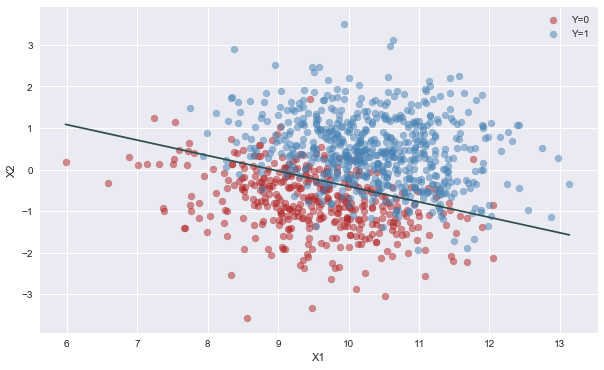

In [11]:
# Generate DataFrame
def generate_data():
    set_seed()
    
    X1 = standard_normal_dist(samples=1000)
    X2 = standard_normal_dist(samples=1000)
    Y = []
    for x1,x2 in zip(X1,X2):
        z = 1 + (2 * x1) + (3 * x2)
        p = logistic(z)
        Y.append(bernoulli_trial(p))
    
    return pd.DataFrame.from_records(data=zip(Y,X1,X2), columns=['Y','X1','X2'])

# Mean shift X1 by 10 to make it 'raw' data
def update_X1_raw(data):
    data['X1'] = data['X1'] + 10
    return data

# Run the logm bootstrap on the raw data, attempting to interpret the results
def experiment_3_no_centering(data):
    
    # Run the logm bootstrap
    result = bootstrap_logm('Y ~ X1 + X2', data=data, samples=100)
    describe_bootstrap_fit(result)
    
    # Interpret the coefficients
    print( "------------------")
    desc_coefficients(result)
    print( "------------------")
    
    # Plot it
    figure = plt.figure(figsize=(10,6))
    axes = figure.add_subplot(1,1,1)

    # Scatter plot of Y = 1 & Y = 0 
    df = result['data']
    dy0 = df[df['Y'] == 0]
    dy1 = df[df['Y'] == 1]    
    
    axes.scatter(dy0['X1'], dy0['X2'], color='firebrick', alpha=0.5, label='Y=0')
    axes.scatter(dy1['X1'], dy1['X2'], color='steelblue', alpha=0.5, label='Y=1')
    axes.set_xlabel('X1')
    axes.set_ylabel('X2')
    axes.legend()

    # plot X2 against X1 (decision boundary)
    x1s = np.linspace(df['X1'].min(), df['X1'].max(), 100)
    b0 = result['coefficients'][0]
    b1 = result['coefficients'][1]
    b2 = result['coefficients'][2]
    x2s = [-((b0 + (b1 * x)) / b2) for x in x1s]

    axes.plot(x1s, x2s, color='darkslategrey')
    plt.show()


# Run experiment 3
data = generate_data()
data = update_X1_raw(data)
experiment_3_no_centering(data)    

**Observations**:
Our model is much more difficult to interpret now. Foremost, the intercept no longer makes any sense, as we know $X_1$ can't be 0.  Additionally the Divide By 4 Anaylsis and Mean of Regressor Analysis for $\beta_1$ are producing distinctly different results, while the analysis for $\beta_2$ is also impacted, indicating we should look closer at our data & approach.

The scatter plot is still informative though.  It immediately tells us our data $X_1$ is *not* centered, though ideally we should find that in a prior EDA and know it going in. Considering we don't trust the coefficients produced by the model, we can't really trust the decision boundary line. 

Regression: Y ~ X1_centered + X2
n: 1000
----------
intercept: 1.183898347946166  95% CI: [0.9711235186643654, 1.432817769938953]
X1_centered: 1.9273151267526312  95% CI: [1.672514380393996, 2.263820135196199]
X2: 3.0702056923952283  95% CI: [2.745334166237022, 3.6126759239077164]
------------------
Coefficients Described:

[Intercept Analysis]:
P(y=1) is 76.56%  with a 95% CI of 72.53% to 80.73% when variables: ['X1_centered', 'X2'] are at 0.

[Divide by 4 Analysis]:
A unit change in X1_centered at its mean would change P(y=1) by 48.18% with a 95% CI of 41.81% to 56.60%
A unit change in X2 at its mean would change P(y=1) by 76.76% with a 95% CI of 68.63% to 90.32%

[Derivative at Mean of Regressor Analysis]:
A unit change in X1_centered at its mean would change P(y=1) by 48.18% with a 95% CI of 41.81% to 56.60%
A unit change in X2 at its mean would change P(y=1) by 76.52% with a 95% CI of 68.47% to 89.94%
------------------


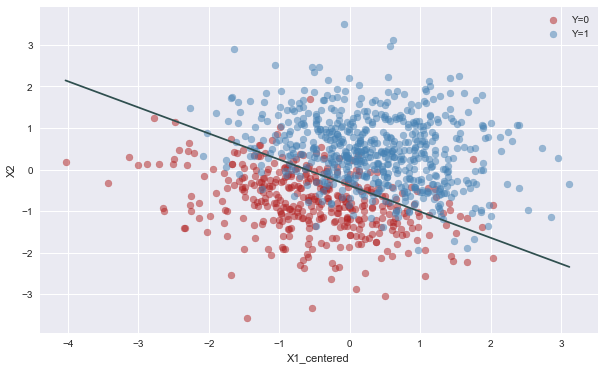

In [12]:
# Run the logm bootstrap on the raw data, attempting to interpret the results
def experiment_3_centered(data):

    # Center X1
    data['X1_centered'] = data['X1'] - data['X1'].mean()
    
    # Run the logm bootstrap
    result = bootstrap_logm('Y ~ X1_centered + X2', data=data, samples=100)
    describe_bootstrap_fit(result)
    
    # Interpret the coefficients
    print( "------------------")
    desc_coefficients(result)
    print( "------------------")
    
    # Plot it
    figure = plt.figure(figsize=(10,6))
    axes = figure.add_subplot(1,1,1)

    # Scatter plot of Y = 1 & Y = 0 
    df = result['data']
    dy0 = df[df['Y'] == 0]
    dy1 = df[df['Y'] == 1]    
    
    axes.scatter(dy0['X1_centered'], dy0['X2'], color='firebrick', alpha=0.5, label='Y=0')
    axes.scatter(dy1['X1_centered'], dy1['X2'], color='steelblue', alpha=0.5, label='Y=1')
    axes.set_xlabel('X1_centered')
    axes.set_ylabel('X2')
    axes.legend()

    # plot X2 against X1 (decision boundary)
    x1s = np.linspace(df['X1_centered'].min(), df['X1_centered'].max(), 100)
    b0 = result['coefficients'][0]
    b1 = result['coefficients'][1]
    b2 = result['coefficients'][2]
    x2s = [-((b0 + (b1 * x)) / b2) for x in x1s]

    axes.plot(x1s, x2s, color='darkslategrey')
    plt.show()
    
    
# Re-run using centered data
data = generate_data()
data = update_X1_raw(data)
experiment_3_centered(data)

**Observations**:  
Clearly mean centering $X_1$ has improved the quality of our model back to the original results we saw in **1**. The intercept now has meaning because $X_1 centered$ has a mean of 0, thus we know $P(Y=1) = 76.56$% when $X_1 centered = 0$, $X_2$ = 0.  The coefficients $\beta_1$ and $\beta_2$ now make a lot more sense and we see parity in the results provided by the two analysis methods (Divide By 4 & Mean of Regressor). Finally, because our coefficients are now safely interpretable, so is the boundary decision line. 

**References:**

- [1] Module 8 Notes: _What is the Logistic Function ?_ 
- [2] Module 8 Notes: _A Continuous Predictor and its Interpretation_
- [3] Module 8 Notes: _Bootstrap Inference_
- [4] Lab 8 Discussion: _Topic: Experiments - [student's name redacted]